In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
def beta_func(t):
    """
    Maps a tensor of times `t` to particular noise levels beta.
    Arguments:
        `t`: a tensor of times
    Returns an equivalently shaped tensor of beta values.
    """
    return torch.sigmoid((t / 6) - 8)


def beta_bar_func(t):
    """
    Maps a tensor of times `t` to beta-bar values. If each beta is a probability
    of a flip at some particular time, then beta-bar is the probability of a
    flip from 0 until this `t`.
    Arguments:
        `t`: a B-tensor of times
    Returns a B-tensor of beta-bar values.
    """
    max_range = torch.arange(1, torch.max(t) + 1, device=DEVICE)
    betas = beta_func(max_range)  # Shape: maxT

    betas_tiled = torch.tile(betas, (t.shape[0], 1))  # Shape: B x maxT
    biases = 0.5 - betas_tiled

    # Anything that ran over a time t, set to 1
    mask = max_range[None] > t[:, None]
    biases[mask] = 1

    prod = torch.prod(biases, dim=1)
    return 0.5 - (torch.pow(2, t - 1) * prod)

In [4]:
def _inflate_dims(v, num_dims):
    """
    Given a tensor vector `v`, appends dimensions of size 1 so that
    it has `num_dims` dimensions. Forexample, if `num_dims` is 3,
    this turns `v` from a B-tensor to a B x 1 x 1 tensor.
    Arguments:
        `v`: a B-tensor
        `num_dims`: an integer greater than 1
    Returns a B x ... tensor of dimension `num_dims`.
    """
    return v[(slice(None),) + ((None,) * (num_dims - 1))]

In [5]:
def noise_input(x0, t):
    """
    Given a binary input at time 0, return a version of the input that
    has noise added to it at time `t` based on random bit flips.
    Arguments:
        `x0`: a binary B x ... tensor of bits at time 0
        `t`: time to add noise to, a B-tensor
    Returns a new binary B x ... tensor, and leaves the originals untouched.
    """
    prob_flip = torch.tile(
        _inflate_dims(beta_bar_func(t), len(x0.shape)), (1, *x0.shape[1:])
    )
    
    flip_indicators = torch.bernoulli(prob_flip)

    # Perform flips
    xt = x0.clone()
    mask = flip_indicators == 1
    xt[mask] = 1 - x0[mask]

    return xt

In [6]:
def posterior_prob(x0, xt, t):
    """
    Compute the probability of a bit at time t - 1, given the bits at time 0
    and t.
    Arguments:
        `x0`: a binary B x ... tensor at time 0
        `xt`: a binary B x ... tensor at time t
        `t`: B-tensor of times
    Returns a B x ... tensor of probabilities that a bit would be 1 at time
    t - 1.
    """
    beta_t = _inflate_dims(beta_func(t), len(x0.shape))
    beta_bar_t = _inflate_dims(beta_bar_func(t), len(x0.shape))
    beta_bar_t_1 = _inflate_dims(beta_bar_func(t - 1), len(x0.shape))

    term_1 = ((1 - xt) * beta_t) + (xt * (1 - beta_t))
    term_2 = ((1 - x0) * beta_bar_t_1) + (x0 * (1 - beta_bar_t_1))
    x0_xor_xt = torch.square(x0 - xt)
    term_3 = (x0_xor_xt * beta_bar_t) + ((1 - x0_xor_xt) * (1 - beta_bar_t))

    return term_1 * term_2 / term_3

In [7]:
class ProbUNet(torch.nn.Module):

    def __init__(
        self, channels=[32, 64, 128, 256], time_embed_size=256, data_channels=1
    ):
        """
        Initialize a time-dependent U-net which predicts bit probabilities.
        Arguments:
            `channels`: the number of channels in each "layer" of the U-net
            `time_embed_size`: size of the time embeddings
            `data_channels`: number of channels in input image
        Note this architecture assumes the initial depth of the images is 1.
        """
        super().__init__()
                
        # Random embedding layer for time; the random weights are set at the
        # start and are not trainable
        self.time_embed_rand_weights = torch.nn.Parameter(
            torch.randn(time_embed_size // 2) * 30, requires_grad=False
        )
        self.time_embed_dense = torch.nn.Linear(time_embed_size, time_embed_size)
        
        # Encoders: receptive field increases and depth increases
        self.conv_e1 = torch.nn.Conv2d(data_channels, channels[0], kernel_size=3, stride=1, bias=False)
        self.time_dense_e1 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_e1 = torch.nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv_e2 = torch.nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.time_dense_e2 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_e2 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_e3 = torch.nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, bias=False)
        self.time_dense_e3 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_e3 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_e4 = torch.nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, bias=False)
        self.time_dense_e4 = torch.nn.Linear(time_embed_size, channels[3])
        self.norm_e4 = torch.nn.GroupNorm(32, num_channels=channels[3])   

        # Decoders: depth decreases
        self.conv_d4 = torch.nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.time_dense_d4 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_d4 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_d3 = torch.nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d3 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_d3 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_d2 = torch.nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d2 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_d2 = torch.nn.GroupNorm(32, num_channels=channels[0])
        
        self.conv_d1 = torch.nn.ConvTranspose2d(channels[0] * 2, data_channels, 3, stride=1, bias=True)

        # Activation functions
        self.swish = lambda x: x * torch.sigmoid(x)  # Swish activation: x * sigmoid(x)
        
    def forward(self, xt, t):
        """
        Forward pass of the network.
        Arguments:
            `xt`: B x 1 x H x W tensor containing the images to train on
            `t`: B-tensor containing the times to train the network for each
                image
        Returns a B x 1 x H x W tensor which consists of predicted probabilities.
        """
        # Get the time embeddings for `t`
        # We first sample vector z from some zero-mean Gaussian (of fixed variance),
        # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
        time_embed_args = t[:, None] * self.time_embed_rand_weights[None, :] * 2 * np.pi
        # Shape: B x (E / 2)
        time_embed = self.swish(
            self.time_embed_dense(
                torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
            )
        )
        # Shape: B x E
        
        # Encoding
        enc_1_out = self.swish(self.norm_e1(
            self.conv_e1(xt) + self.time_dense_e1(time_embed)[:, :, None, None]
        ))
        enc_2_out = self.swish(self.norm_e2(
            self.conv_e2(enc_1_out) + self.time_dense_e2(time_embed)[:, :, None, None]
        ))
        enc_3_out = self.swish(self.norm_e3(
            self.conv_e3(enc_2_out) + self.time_dense_e3(time_embed)[:, :, None, None]
        ))
        enc_4_out = self.swish(self.norm_e4(
            self.conv_e4(enc_3_out) + self.time_dense_e4(time_embed)[:, :, None, None]
        ))
            
        # Decoding
        dec_4_out = self.swish(self.norm_d4(
            self.conv_d4(enc_4_out) + self.time_dense_d4(time_embed)[:, :, None, None]
        ))
        dec_3_out = self.swish(self.norm_d3(
            self.conv_d3(torch.cat([dec_4_out, enc_3_out], dim=1)) + self.time_dense_d3(time_embed)[:, :, None, None]
        ))
        dec_2_out = self.swish(self.norm_d2(
            self.conv_d2(torch.cat([dec_3_out, enc_2_out], dim=1)) + self.time_dense_d2(time_embed)[:, :, None, None]
        ))
        dec_1_out = self.conv_d1(torch.cat([dec_2_out, enc_1_out], dim=1))
        
        return torch.sigmoid(dec_1_out)

    def loss(self, pred_probs, true_probs):
        """
        Computes the loss of a batch.
        Arguments:
            `pred_probs`: a B x 1 x H x W tensor of predicted
                probabilities
            `true_probs`: a B x 1 x H x W tensor of true
                probabilities
        Returns a B-tensor of loss values.
        """
        return torch.nanmean(
            (true_probs * torch.log(true_probs / pred_probs)) +
            ((1 - true_probs) * torch.log((1 - true_probs) / (1 - pred_probs))),
            dim=(1, 2, 3)
        )

In [8]:
def train_model(model, data_loader, t_limit, num_epochs, learning_rate):
    """
    Trains a ProbUNet model.
    Arguments:
        `model`: an initialized ProbUNet model
        `data_loader`: a DataLoader which iterates over batches of
            discretized images and labels (labels will be unused)
        `t_limit`: maximum time range for noising
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    torch.set_grad_enabled(True)

    for epoch_num in range(num_epochs):
        losses = []
        t_iter = tqdm.notebook.tqdm(
            data_loader, total=len(data_loader), desc="Loss: -----"
        )

        for x0, _ in t_iter:
            x0 = x0.to(DEVICE)

            # Pick some random times t between 1 and t_limit (inclusive)
            t = torch.randint(
                t_limit, size=(x0.shape[0],), device=DEVICE
            ) + 1

            # Add noise to inputs from time 0 to time t
            xt = noise_input(x0, t)

            # Compute posterior probability of bits
            true_probs = posterior_prob(x0, xt, t)

            # Have model try and predict posterior probability
            pred_probs = model(xt, t)

            loss = torch.mean(model.loss(pred_probs, true_probs))
            
            if not np.isfinite(loss.item()):
                continue
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_iter.set_description(
                "Loss: %6.5f" % loss.item()
            )
            losses.append(loss.item())

        print("Epoch %d average loss: %.5f" % (epoch_num + 1, np.mean(losses)))
        torch.save(model.state_dict(), "ckpt.pth")

In [9]:
image_to_tensor = torchvision.transforms.ToTensor()
dataset = torchvision.datasets.MNIST(
    '/gstore/data/resbioai/tsenga5/', train=True, transform=(lambda x: torch.round(image_to_tensor(x)))
)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

t_limit = 50

In [10]:
def plot_digits(x, num_to_plot=10, title=None):
    fig, ax = plt.subplots(ncols=num_to_plot, figsize=(20, 4))
    for i in range(num_to_plot):
        ax[i].imshow(x[i].permute(1, 2, 0), cmap="gray")
        ax[i].axis('off')
    if title:
        ax[0].set_title(title)
    plt.show()

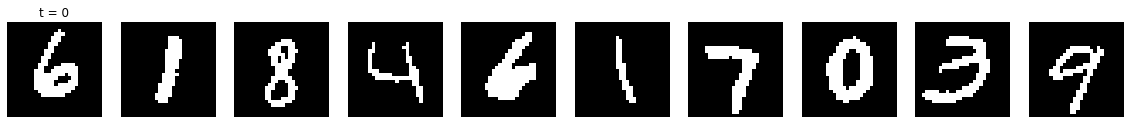

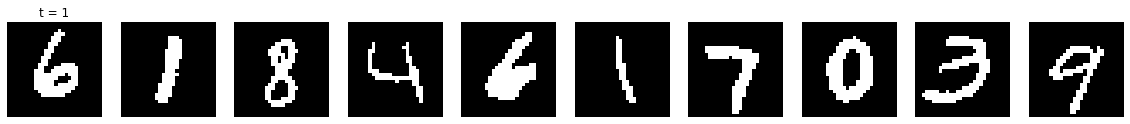

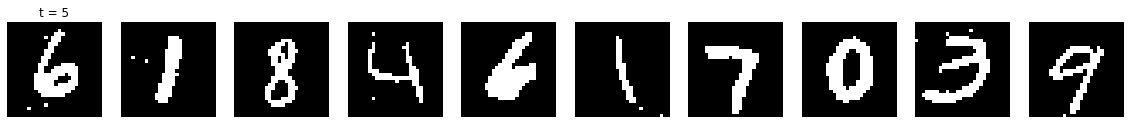

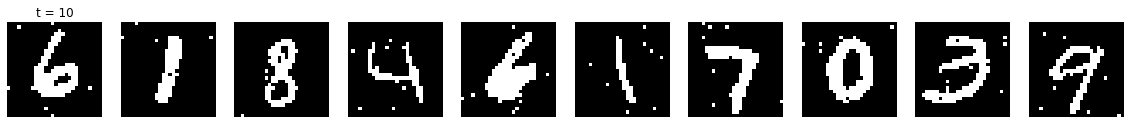

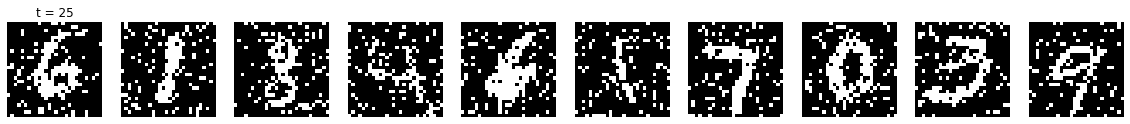

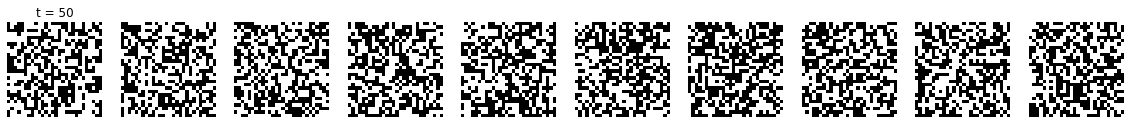

In [11]:
# Plot some examples of noised images
x0, _ = next(iter(data_loader))
    
plot_digits(np.clip(x0, 0, 1), title="t = 0")
x0 = x0.to(DEVICE)
for t in (1, 5, 10, 25, t_limit):
    xt = noise_input(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_digits(torch.clamp(xt, 0, 1).cpu(), title=("t = %d" % t))

  0%|          | 0/49 [00:00<?, ?it/s]

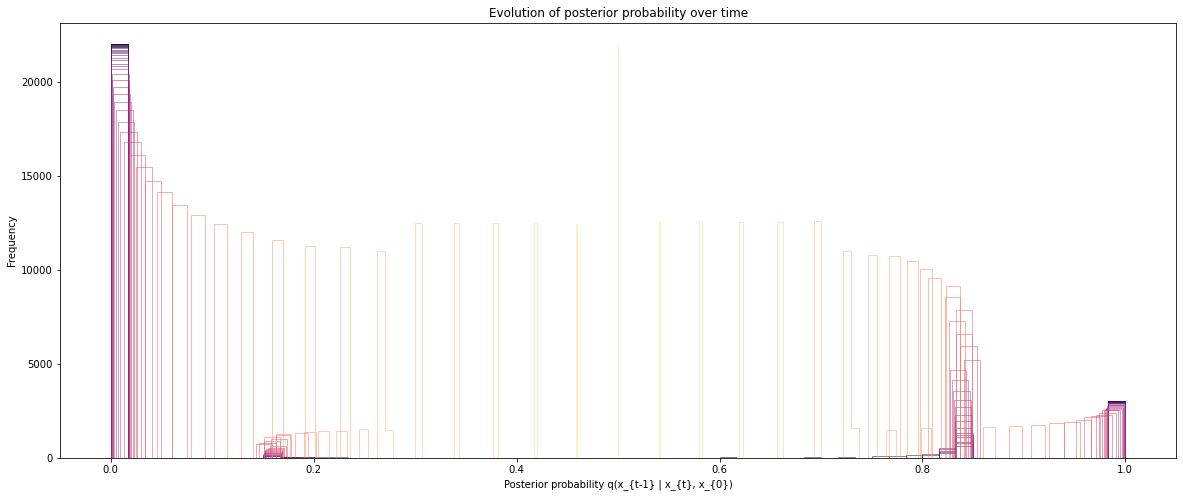

In [12]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
x0, _ = next(iter(data_loader))
posterior_probs = np.empty((len(t_vals), *x0.shape))
x0 = x0.to(DEVICE)
t_0 = torch.zeros(x0.shape[0], device=DEVICE)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.ones(x0.shape[0], device=DEVICE) * t
    xt = noise_input(x0, t_tens)
    p = posterior_prob(x0, xt, t_tens)
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 8))
posterior_probs_flattened = posterior_probs.reshape(posterior_probs.shape[0], -1)
times = np.tile(t_vals[:, None], (1, posterior_probs_flattened.shape[1]))
cmap = plt.get_cmap("magma")
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs_flattened[t_i], bins=60, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

In [13]:
model = ProbUNet().to(DEVICE)
train_model(
    model, data_loader,
    t_limit=t_limit,
    num_epochs=10,
    learning_rate=0.001
)

Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 average loss: 0.01813


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 average loss: 0.00437


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 average loss: 0.00353


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 average loss: 0.00302


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 average loss: 0.00278


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 average loss: 0.00263


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 average loss: 0.00247


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 average loss: 0.00238


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 average loss: 0.00234


Loss: -----:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 average loss: 0.00231


Sampling some reverse trajectories


  0%|          | 0/48 [00:00<?, ?it/s]

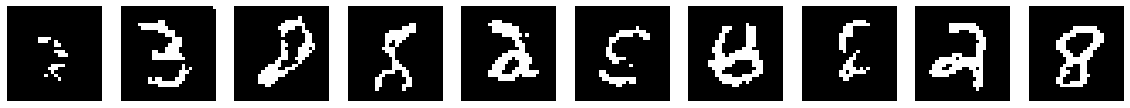

In [14]:
# Take the trained model and go backwards to sample some digits
print("Sampling some reverse trajectories")
torch.set_grad_enabled(False)

batch_size = 32
xt = np.random.randint(2, size=(batch_size, 1, 28, 28)).astype(float)
xt = torch.tensor(xt).float().to(DEVICE)

for t in tqdm.notebook.trange(t_limit - 1, 1, -1):
    probs = model(xt, torch.ones(batch_size, device=DEVICE) * t)
    
    xt = torch.bernoulli(probs)

plot_digits(xt.cpu(), num_to_plot=10)